Ce programme décrit les étapes établies pour l'extraction de relations entre les différents claims postés dans chaque rubrique sur le site Fullfact. Nous avons utilisé pour cela le classifier Kmeans (classification non-supervisée) car nous n'avons pas les labels de classes pour lesquels nous voulons regrouper les claims. Autrement dit, le but est d'essayer de trouver les relations entre les claims postés dans chaque rubrique (si elles existent).





In [1]:
#Les imports necessaires au programme.
import sys
import import_ipynb
import pandas as pd
import Claim as claim_obj
from nltk import word_tokenize , sent_tokenize 
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import TraitementConclusion
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.decomposition import PCA
import pickle
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer

importing Jupyter notebook from Claim.ipynb
importing Jupyter notebook from TraitementConclusion.ipynb


/home/nihedb/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Le site Fullfact contient au total 4 rubriques dans lesquelles les journalistes postent leurs revues: Health, Economy, Europe et Online. 
Nous avons donc lancé notre programme extracteur et avons récupéré un ensemble de  claims pour chaque rubrique.
Nous avons stocké ces claims dans des fichiers pour pouvoir les manipuler et faire nos expérimentations sans avoir à lancer l'extracteur à chaque fois.


Remarque : Lors de l'extraction, nous récupérons les claims ainsi que leurs titres car nous avons remarqué que le titre peut être souvent très indicateur quant à la relation qui existe entre les claims ( il contient des mots clés ou une reformulation du claim avec des mots existants dans les autres claims). 

In [2]:
negation=["no", "not","neither", "nor"]
pays=["eu", "uk", "us"]
ponctuation=[".",",","!",";","?", "'", "â€˜", "â€™"]
mots=["people", "new", "list", "years", "days"]
categorie=["economy", "health", "europe", "online"]
stop_words = stopwords.words('english')

rubHealth=[]
rubEconomy=[]
rubEurope=[]
rubOnline=[]
def loadData(nomRubrique, nomFichier):
 
    with open(nomFichier, 'rb') as fichier:
        mon_depickler = pickle.Unpickler(fichier)
        nomRubrique=mon_depickler.load()
    fichier.close()
    return nomRubrique


rubHealth=loadData(rubHealth,'health')
rubEconomy=loadData(rubEconomy,'economy')
rubEurope=loadData(rubEurope,'europe')
rubOnline=loadData(rubOnline,'online')




Une fois tous les claims recupérés, nous procédons au nettoyage du texte. Ainsi, nous commençons par dissocier les contractions,enlever les stop words, la ponctuation et les caractères spéciaux. Ensuite, nous appliquons la lemmatization sur les mots pour les transformer sous une forme canonique.
Enfin, nous appliquons un analyseur morphosyntaxique sur notre texte afin de ne garder que les noms et les adjectifs.

In [3]:
def traitementPosts(post):
    tempo=[]
    resultat=[]
    pos= TraitementConclusion.nettoyage(post)
    pos=TraitementConclusion.lemmatization(pos)
    result= TraitementConclusion.eliminationStopWords(pos)
    result= [word for word in result if word not in ponctuation and word not in mots]  
    for r in result:
        if ("-" in r):
            k=r.replace("-","")
            result.remove(r)
            if k not in result:
                result.append(k)
    clean_sample_list = [word for word in result if word]
    tempo=nltk.pos_tag(clean_sample_list)
    #print(tempo)
    i=0
    while i < len(tempo):
        if (tempo[i][1] == 'NN' or tempo[i][1] == 'NNS'):
            if tempo[i][0] not in resultat:
                resultat.append(tempo[i][0])
        i+=1       
    phrase= " ".join(resultat)  
    return phrase



def traitementRelatedPosts(relp,keyWords, posts):
    
    for v in relp:
        if(v[0] not in categorie and v[0] not in keyWords):
            keyWords.append(v[0])
        post= v[2] + " " + v[3]
        post= post.replace(".", "")
        #print(post)
        ph=traitementPosts(post)
        posts.append(ph)
     
    return posts
 




Ensuite, nous avons appliqué la méthode "Elbow" qui a pour but de trouver le bon k pour fragmenter nos données. Cette méthode consiste à lancer K-Means avec différentes valeurs de K et de calculer la variance des différents clusters. La bonne valeur de k se trouve dans le point du graphe qui représente le coude (d'où le nom de "elbow").

In [4]:
def getElbow(corpus):
    vectorizer = CountVectorizer()
    res= vectorizer.fit_transform(corpus)      
    visualizer=KElbowVisualizer(KMeans(), k=(2,10), timings=False)
    visualizer.fit(res)        # Fit the data to the visualizer
    visualizer.show()
    



Voici donc ce que cela donne avec la rubrique Health:

/home/nihedb/env/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/nihedb/env/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


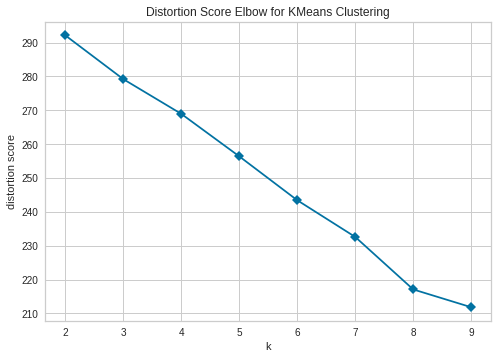

In [5]:
posts=[]
keyWords=[]
retour= traitementRelatedPosts(rubHealth,keyWords, posts)
getElbow(retour)

Et sur la rubrique Economy :

/home/nihedb/env/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/nihedb/env/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


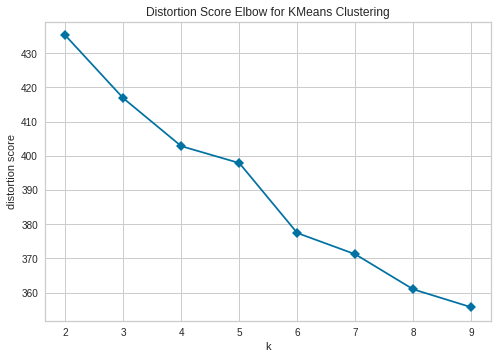

In [6]:
posts=[]
keyWords=[]
retour= traitementRelatedPosts(rubEconomy,keyWords, posts)
getElbow(retour)

Rubrique Europe :

/home/nihedb/env/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/nihedb/env/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


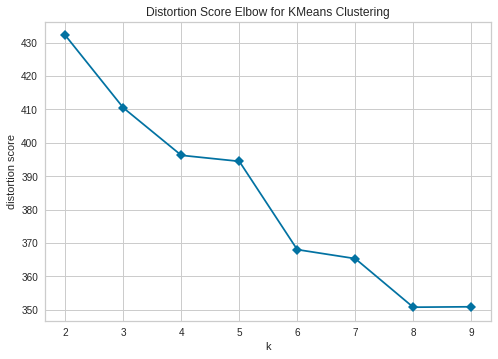

In [7]:
posts=[]
keyWords=[]
retour= traitementRelatedPosts(rubEurope,keyWords, posts)
getElbow(retour)

Rubrique online:

/home/nihedb/env/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/nihedb/env/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


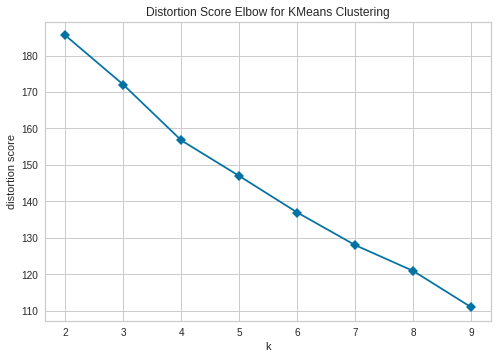

In [8]:
posts=[]
keyWords=[]
retour= traitementRelatedPosts(rubOnline,keyWords, posts)
getElbow(retour)

L'étape suivante consiste  à :
  1. construire une matrice à partir de nos claims prétraités et à appliquer kmeans avec le bon k pour chaque      jeu de données (rubrique). 
  2. Afficher notre matrice de mots et le résultat de kmeans sur un plan 2D pour visualiser les clusters construits ainsi que leurs centroids.
  3. Afficher les top 5 mots de chaque cluster.
  
Voici donc le code qui permet de faire cela. à noter que la matrice a été construite à partir du score TF-IDF des mots des claims.


In [14]:
def getLiensPosts(posts, true_k, rubrique):
    
    vectorizer = TfidfVectorizer()
 

    df = pd.DataFrame(
    data=vectorizer.fit_transform(posts).toarray(),
    columns=vectorizer.get_feature_names()
    )
    res= vectorizer.fit_transform(posts)
  

    model = KMeans(n_clusters=true_k)
    model.fit(res)
    
    kmeans_indices = model.fit_predict(res)
   
    pca = PCA(n_components=2).fit(res.todense())
    data2D = pca.transform(res.todense())
    centers = np.array(pca.transform(model.cluster_centers_))
    plt.title('Visualisation du résultat de Kmeans et de la distribution des données ( '+rubrique+' )')
    plt.scatter(data2D[:,0], data2D[:,1], c=kmeans_indices , cmap='rainbow')


    plt.scatter(centers[:,0], centers[:,1], marker="x", color='black')
    plt.figure(figsize=(16,8))
  
    plt.show()


   
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
  

    print("Top terms per cluster ( " +rubrique+" )")
    for i in range(true_k):
        for ind in order_centroids[i, :5]:
            print(terms[ind])
        print("-----end cluster-----")
    return (terms[order_centroids[0][0]])
  

    
def fonctionPRelatedPosts(relp, true_k, rubrique):
    posts=[]
    keyWords=[]
    #true_k=3
    retour= traitementRelatedPosts(relp,keyWords, posts)
    f=getLiensPosts(retour, true_k, rubrique)
    if f not in keyWords:
        keyWords.append(f)
    
    return keyWords





Voici donc le résultat de la classification sur l'ensemble des rubriques:

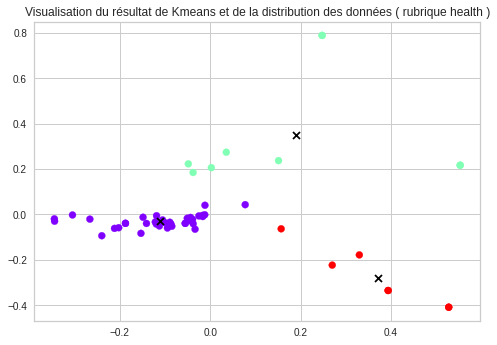

<Figure size 1152x576 with 0 Axes>

Top terms per cluster ( rubrique health )
nhs
health
number
year
fund
-----end cluster-----
covid19
patients
disease
recover
catch
-----end cluster-----
coronavirus
spread
network
wifi
children
-----end cluster-----


['nhs']

In [27]:
fonctionPRelatedPosts(rubHealth,3, "rubrique health")


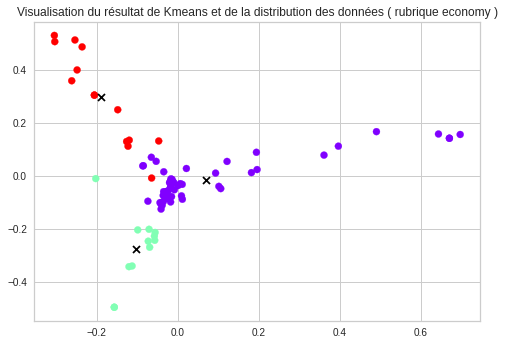

<Figure size 1152x576 with 0 Axes>

Top terms per cluster ( rubrique economy )
fare
rail
rise
economy
government
-----end cluster-----
poverty
uk
skyrocket
child
families
-----end cluster-----
pay
gap
women
gender
men
-----end cluster-----


['fare']

In [29]:
fonctionPRelatedPosts(rubEconomy,3, "rubrique economy")


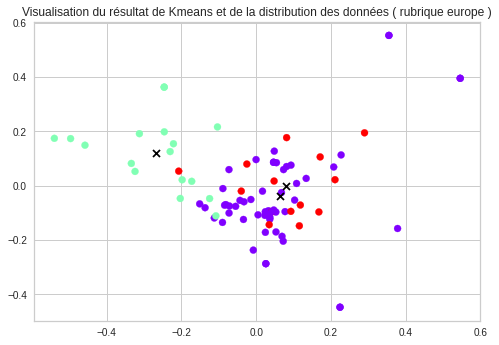

<Figure size 1152x576 with 0 Axes>

Top terms per cluster ( rubrique europe )
eu
trade
market
export
economy
-----end cluster-----
brexit
deal
cost
extension
month
-----end cluster-----
union
europe
customs
seekers
asylum
-----end cluster-----


['eu']

In [31]:
fonctionPRelatedPosts(rubEurope,3, "rubrique europe")


    account     admit    advice  announce  antimalaria   anyone     april  \
0   0.00000  0.000000  0.000000  0.000000     0.000000  0.00000  0.000000   
1   0.00000  0.000000  0.000000  0.000000     0.000000  0.00000  0.000000   
2   0.00000  0.000000  0.000000  0.000000     0.000000  0.00000  0.464557   
3   0.00000  0.000000  0.000000  0.000000     0.000000  0.00000  0.000000   
4   0.00000  0.000000  0.000000  0.000000     0.000000  0.00000  0.000000   
5   0.00000  0.000000  0.000000  0.000000     0.000000  0.00000  0.000000   
6   0.00000  0.000000  0.000000  0.363307     0.000000  0.00000  0.000000   
7   0.00000  0.000000  0.000000  0.000000     0.000000  0.00000  0.000000   
8   0.00000  0.000000  0.000000  0.000000     0.000000  0.00000  0.000000   
9   0.00000  0.000000  0.365742  0.000000     0.000000  0.00000  0.000000   
10  0.00000  0.000000  0.000000  0.000000     0.407369  0.00000  0.000000   
11  0.00000  0.000000  0.000000  0.000000     0.000000  0.00000  0.000000   

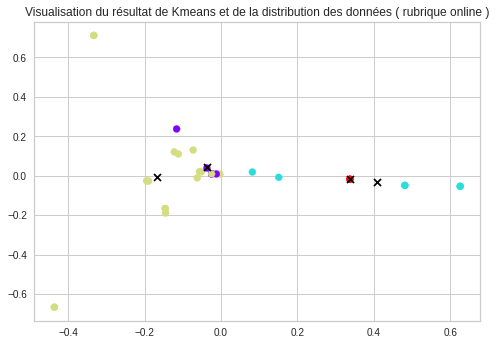

<Figure size 1152x576 with 0 Axes>

Top terms per cluster ( rubrique online )
attack
heart
cough
cpr
money
-----end cluster-----
uk
facebook
mcdonald
april
reopen
-----end cluster-----
post
covid19
location
coronavirus
giza
-----end cluster-----
relocate
phone
case
students
mobile
-----end cluster-----


['attack']

In [13]:

fonctionPRelatedPosts(rubOnline, 4, "rubrique online")



Analyse du résultat obtenu :

Sur la rubrique health et economy, l'algorithme à un meilleur résultat (regroupement des points proches dans le même cluster et espacement des clusters entre eux) que sur les rubriques europe ou online. Nous nous attendions en partie à ce résutat car lors de l'analyse manuelle du site nous avons remarqué que les rubriques online et europe ne traitent pas des thématiques bien définies (online peut contenir des claims qui ont des thématiques qui concernent la santé ou l'économie par exemple) donc le regroupement est plus difficile à réaliser.
